In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
import random
import pickle

import pymc3 as pm
import theano.tensor as T
import exoplanet as xo

import caustic as ca

random.seed(42)

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

# Print library version numbers
print("Numpy version", np.__version__)
print("PyMC3 version", pm.__version__)

%config InlineBackend.figure_format = 'retina'

Numpy version 1.13.0
PyMC3 version 3.7


In [2]:
event_ogle = ca.data.OGLEData("../../../data/OGLE_ews/2017/blg-0324")

In [3]:
# Update mask
mask = event_ogle.light_curves[0]['HJD'] - 2450000 < 7830
event_ogle.light_curves[0]['mask'] = mask

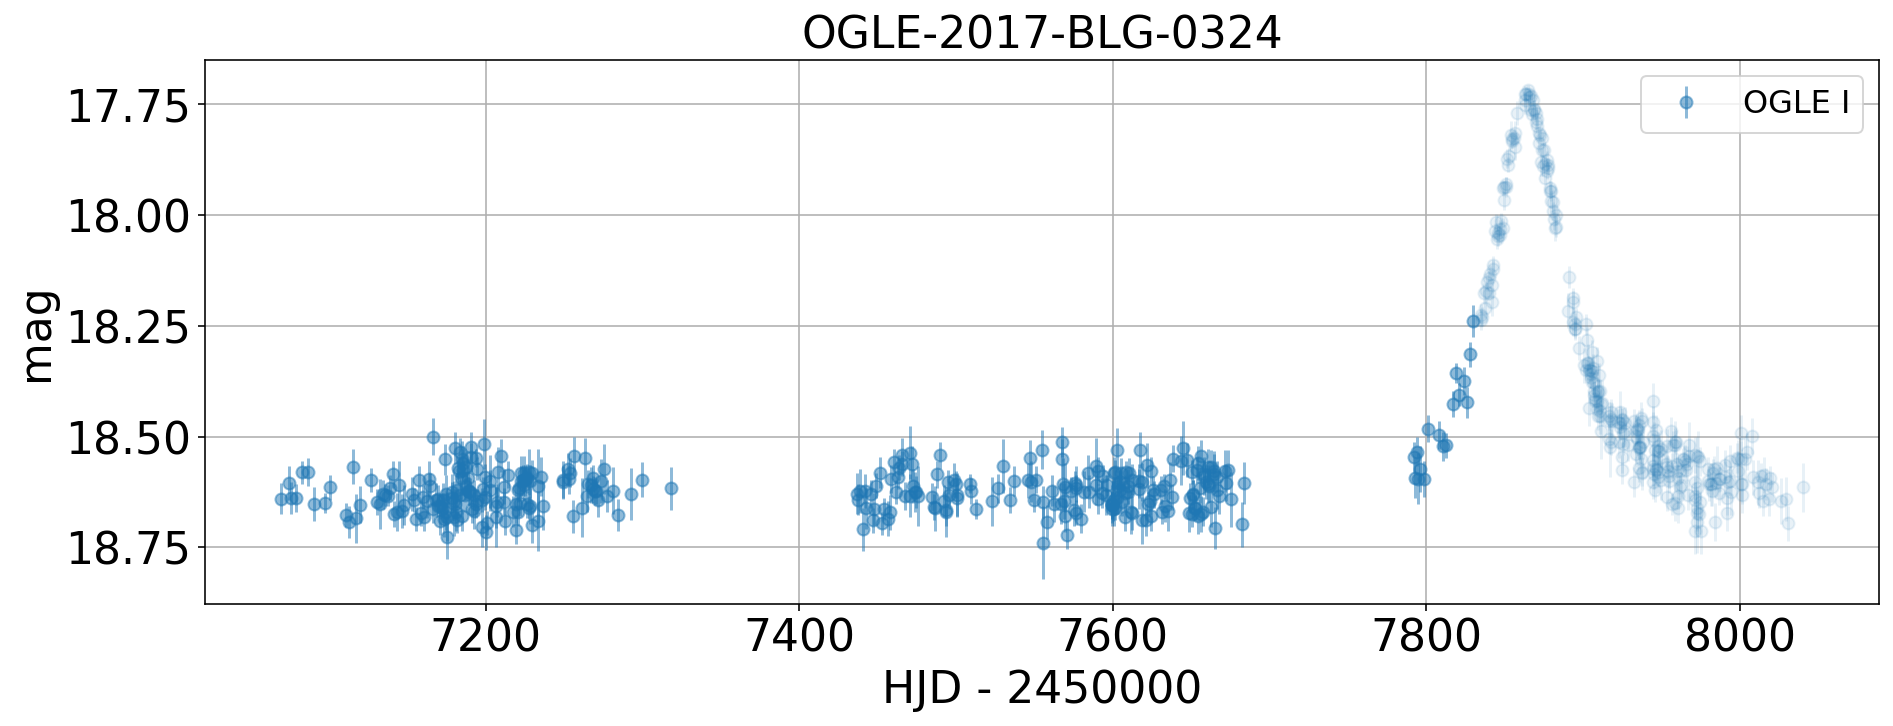

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
event_ogle.plot(ax)

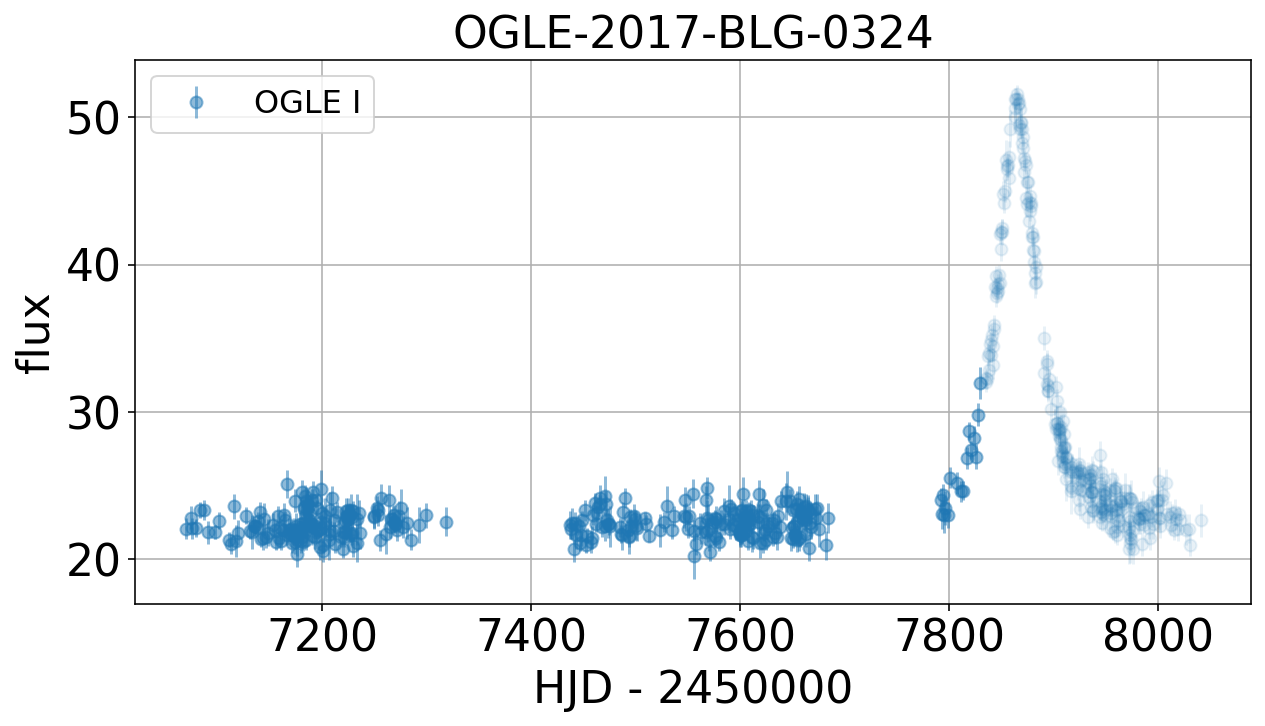

In [5]:
event_ogle.units = 'fluxes'
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot(ax)

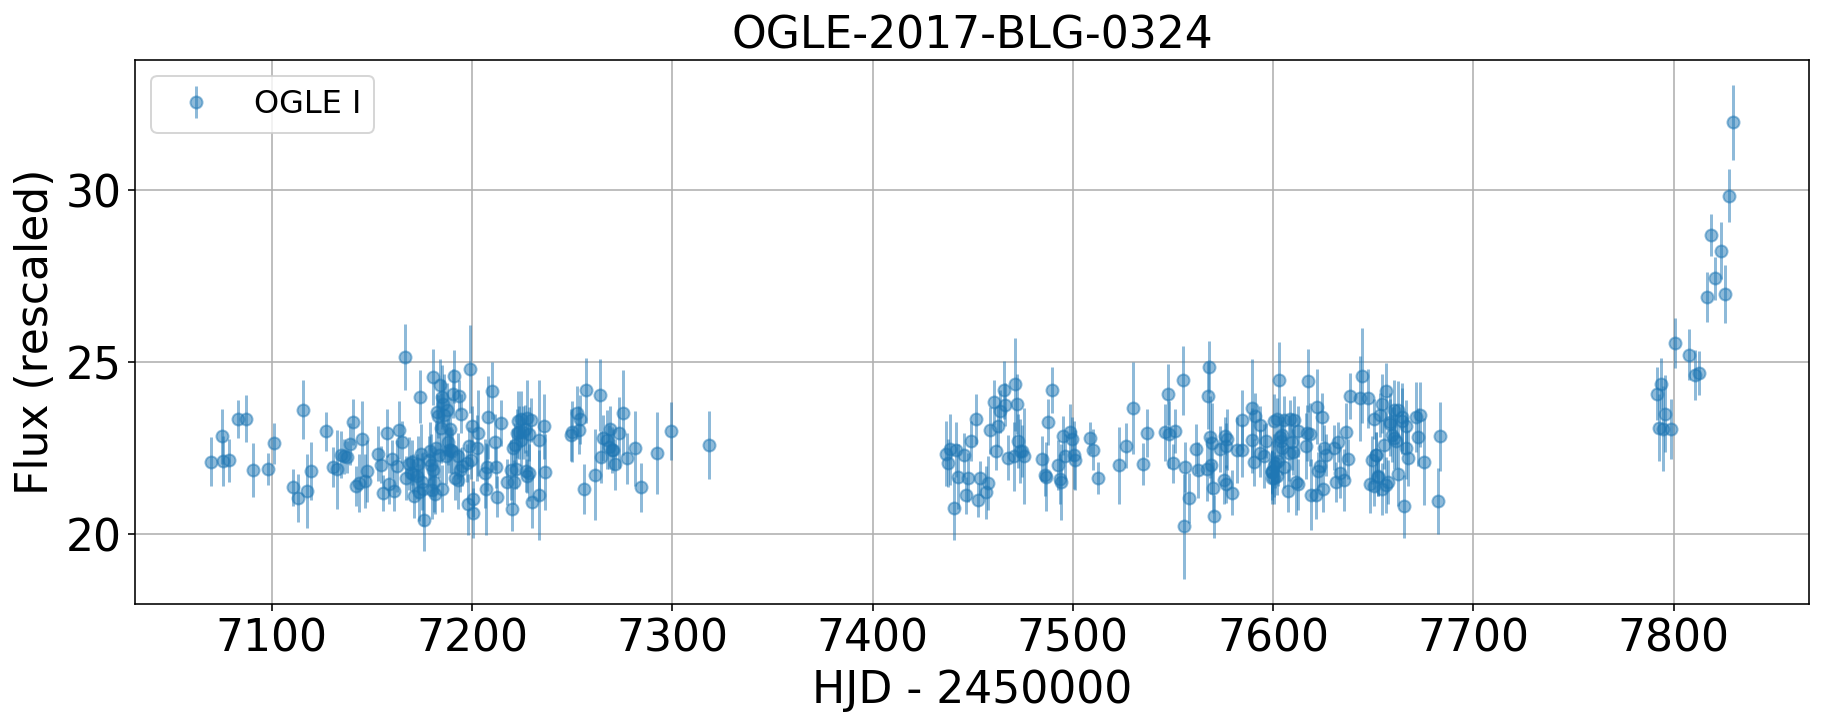

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
event_ogle.plot_standardized_data(ax, rescale=False)

# Fit event on its own

In [7]:
# Initialize a SingleLensModel object
pspl_model = ca.models.SingleLensModel(event_ogle, standardize=False) 

In [8]:
n_bands = len(event_ogle.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with pspl_model:
    # Initialize linear parameters   
    init_ln_Delta_F = np.log(ca.utils.estimate_peak_flux(event_ogle) -\
        ca.utils.estimate_baseline_flux(event_ogle))
    
    ln_Delta_F = pm.Normal('ln_Delta_F', 
        mu=5.*T.ones(n_bands),
        sd=10.*T.ones(n_bands),
        testval=T.as_tensor_variable(init_ln_Delta_F),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=1e3*T.ones(n_bands),
        testval=T.as_tensor_variable(ca.utils.estimate_baseline_flux(event_ogle)),
        shape=(n_bands))
    
    # Initialize non-linear parameters
    ## Posterior is multi-modal in t0 and it's critical that the it is 
    ## initialized near the true value
    t_mid = (pspl_model.t_max - pspl_model.t_min)/2
    t_range = pspl_model.t_max - pspl_model.t_min
    t_0 = pm.Normal('t_0', t_mid, 2*t_range,
        testval=ca.utils.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    ln_teff = pm.Normal('ln_t_eff', mu=3., sd=5., testval=4.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", T.exp(ln_teff)/u_0) 
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(event_ogle, 
                                pspl_model, T.exp(ln_Delta_F), F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(pspl_model.t)
        
    # Compute the magnification
    mag = pspl_model.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = T.exp(ln_Delta_F)*mag + F_base
    
    # We allow for rescaling of the error bars by a constant factor
    c = BoundedNormal_1('c', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c*pspl_model.sig_F)**2
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = pspl_model.compute_log_likelihood(pspl_model.F - mean, var_F)
    pm.Potential('log_likelihood', ll)

In [9]:
with pspl_model:  
    # Print initial logps
    initial_logps = [RV.logp(pspl_model.test_point) for RV in pspl_model.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace = pm.sample(tune=1000, draws=4000, cores=4, step=xo.get_dense_nuts_step(target_accept=0.95))

Initial values of log priors: [array(-3.2765490579821925), array(-7.826945655463614), array(-20.24558419321984), array(-3.6292109565291044), array(-2.548376445638773), array(-2.3364828943245635)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ln_t_eff, u_0, t_0, F_base, ln_Delta_F]
Sampling 4 chains: 100%|██████████| 20000/20000 [02:58<00:00, 29.99draws/s]
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.907234831241, but should be close to 0.95. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.900699084447, but should be close to 0.95. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.87748550434, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 1

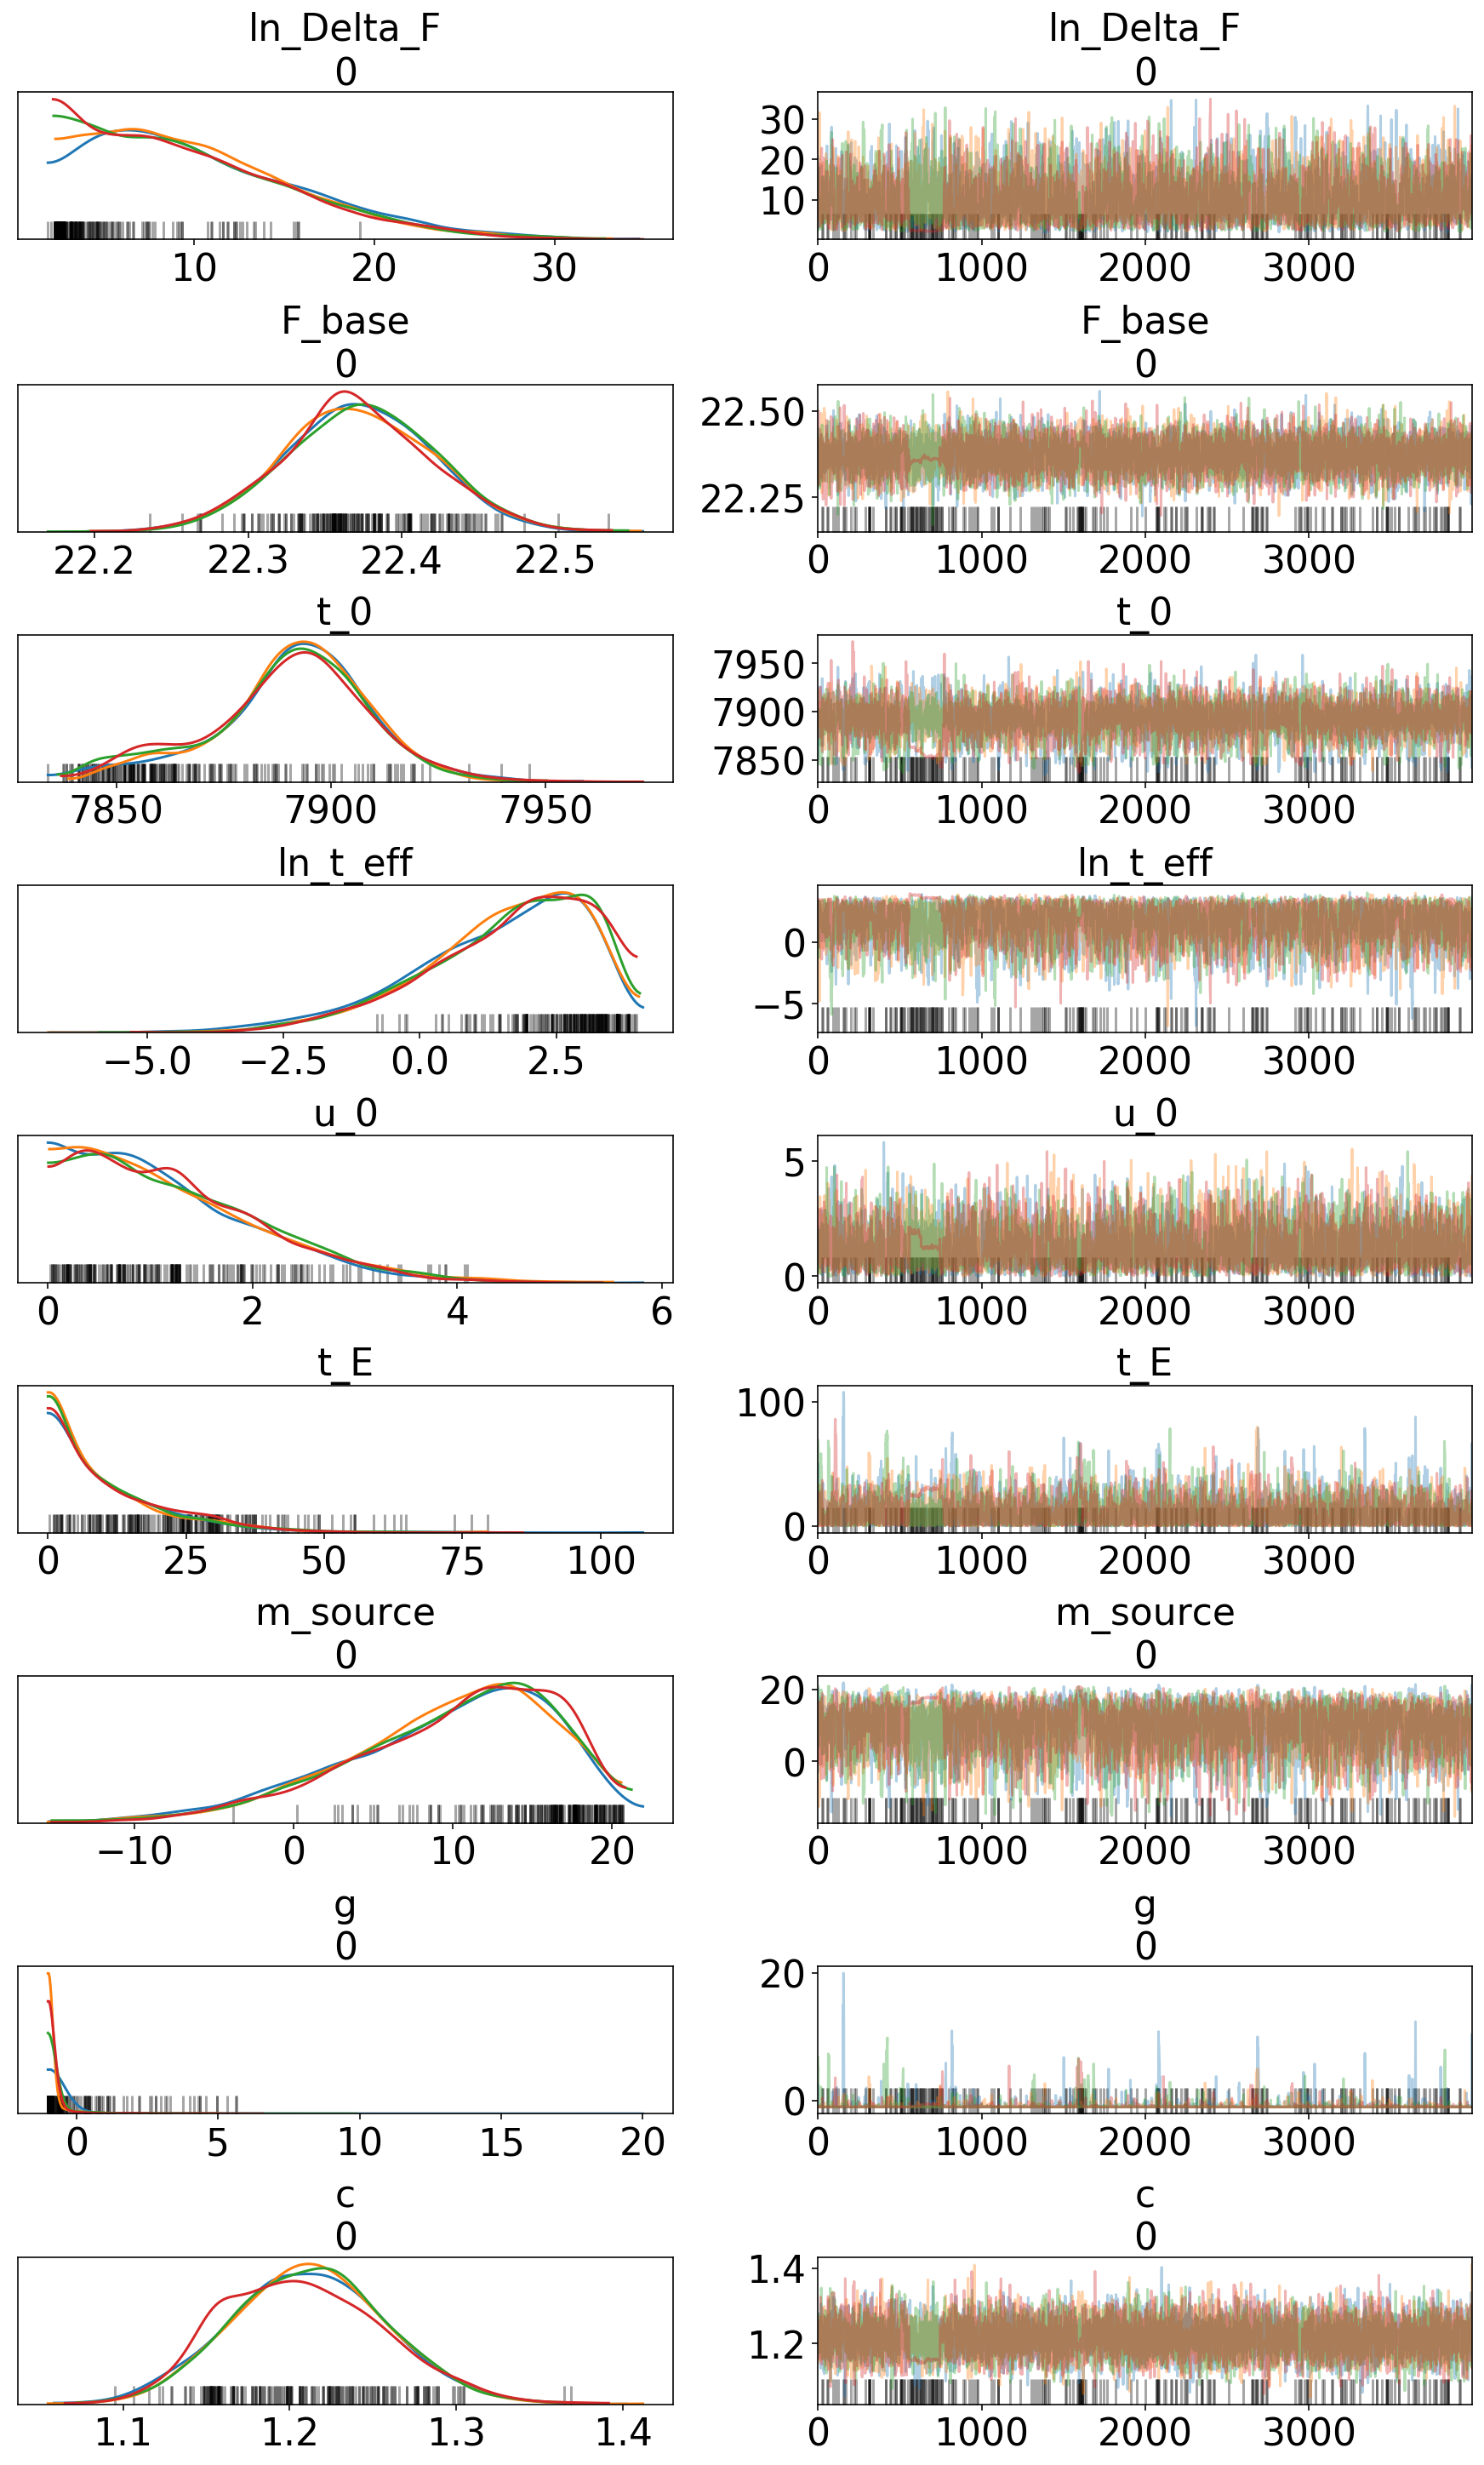

In [10]:
pm.traceplot(trace, figsize=(12, 20));

In [11]:
with pspl_model:
    # Create dense grid
    t_dense = np.tile(np.linspace(pspl_model.t_min, 8000, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)
    
    # Compute the magnification
    mag_dense = pspl_model.compute_magnification(u_dense, u_0)
    
    # Compute the mean model
    mean_dense = T.exp(ln_Delta_F)*mag_dense + F_base

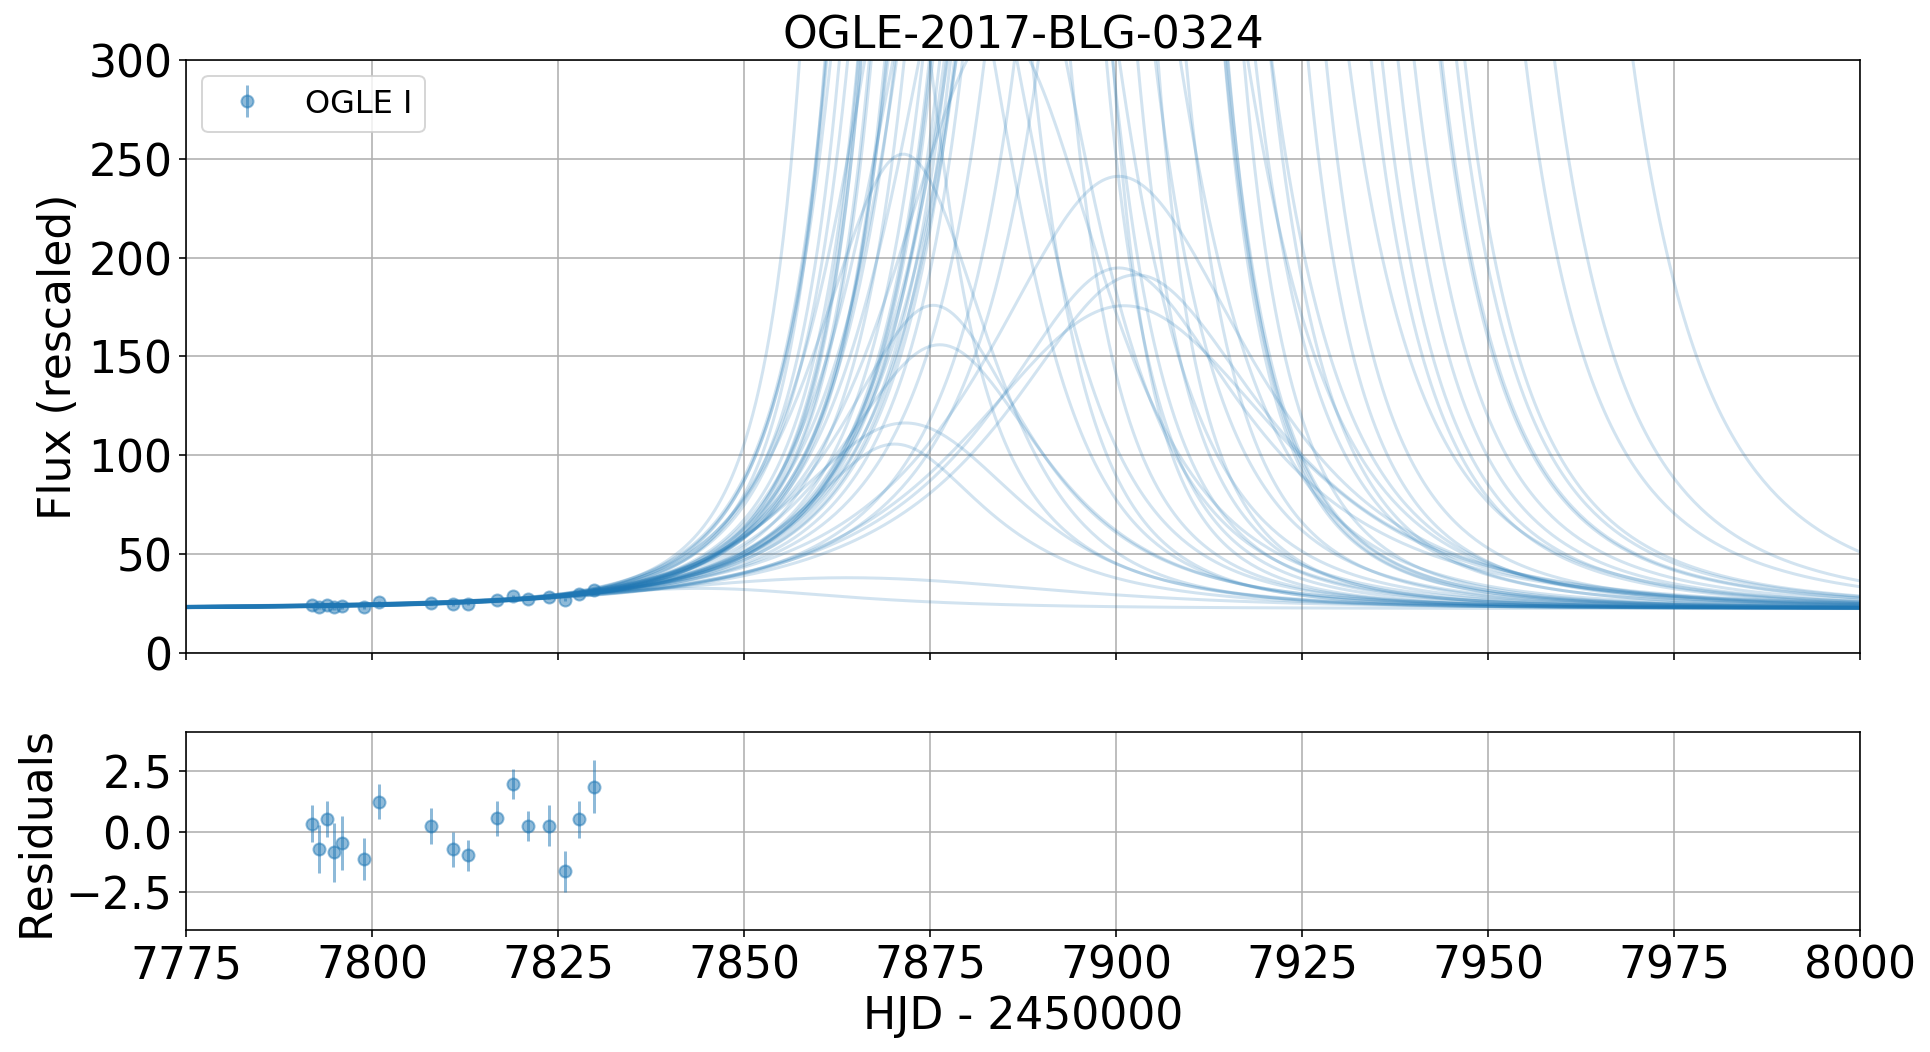

In [12]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(15, 8), sharex=True)

ax[0].set_ylim(0, 300)
ax[0].set_xlim(7775, 8000)
ca.plot_model_and_residuals(ax, event_ogle, pspl_model, trace, t_dense_tensor, mean_dense, n_samples=50)

# Fit hierarchical predictive model

First, we load the samples of the hyperparameters which parametrize the population level distribution of the parameter $\ln\Delta F$. 
These were previously computed by fitting a bunch of OGLE events with a simple PSPL model.

In [13]:
# Load hyperparameter samples
samples_hyper = np.load('samples_hyper.npy')

# Thin samples, convert to theano tensor
samples_tensor = T.as_tensor_variable(samples_hyper)

In [14]:
# Initialize a SingleLensModel object
model_predictive = ca.models.SingleLensModel(event_ogle, standardize=False) 

In [15]:
with model_predictive:
    # Initialize linear parameters   
    init_ln_Delta_F = np.log(ca.utils.estimate_peak_flux(event_ogle) -\
        ca.utils.estimate_baseline_flux(event_ogle))
    
    ln_Delta_F = pm.Normal('ln_Delta_F', 
        mu=5.*T.ones(n_bands),
        sd=10.*T.ones(n_bands),
        testval=T.as_tensor_variable(init_ln_Delta_F),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=1e3*T.ones(n_bands),
        testval=T.as_tensor_variable(ca.utils.estimate_baseline_flux(event_ogle)),
        shape=(n_bands))   
    
    # Initialize non-linear parameters
    ## Posterior is multi-modal in t0 and it's critical that the it is 
    ## initialized near the true value
    t_mid = (model_predictive.t_max - model_predictive.t_min)/2
    t_range = model_predictive.t_max - model_predictive.t_min
    t_0 = pm.Normal('t_0', t_mid, 2*t_range,
        testval=ca.utils.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    ln_teff = pm.Normal('ln_t_eff', mu=3., sd=5., testval=4.)

    # Deterministic transformations
    t_E = pm.Deterministic("t_E", T.exp(ln_teff)/u_0) 
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(event_ogle, 
                                model_predictive, T.exp(ln_Delta_F), F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(model_predictive.t)
        
    # Compute the magnification
    mag = model_predictive.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = T.exp(ln_Delta_F)*mag + F_base
    
    # We allow for rescaling of the error bars by a constant factor
    c = BoundedNormal_1('c', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c*model_predictive.sig_F)**2
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll_single = model_predictive.compute_log_likelihood(model_predictive.F - mean, var_F)
    
    # Compute additional term for the likelihood
    mu = samples_tensor[:, 0]
    sig = samples_tensor[:, 1]

    # Iterate over samples from hyperparameters
    array = T.exp(-0.5*(ln_Delta_F - mu)**2/sig**2)/T.sqrt(2*np.pi*sig**2)
        
    ll_hyper = T.log(T.sum(array))
    
    subtract = pm.Normal.dist(
        mu=5.*T.ones(n_bands),
        sd=10.*T.ones(n_bands),
        shape=(n_bands)).logp(ln_Delta_F)
    
    pm.Potential('log_likelihood', ll_single + ll_hyper - subtract)

In [16]:
with model_predictive:
    # Print initial logps
    initial_logps = [RV.logp(model_predictive.test_point) for RV in model_predictive.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace_predictive = pm.sample(tune=2000, draws=5000, cores=4, step=xo.get_dense_nuts_step(target_accept=0.9))

Initial values of log priors: [array(-3.2765490579821925), array(-7.826945655463614), array(-20.24558419321984), array(-3.6292109565291044), array(-2.548376445638773), array(-2.3364828943245635)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ln_t_eff, u_0, t_0, F_base, ln_Delta_F]
Sampling 4 chains: 100%|██████████| 28000/28000 [01:27<00:00, 320.59draws/s]
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


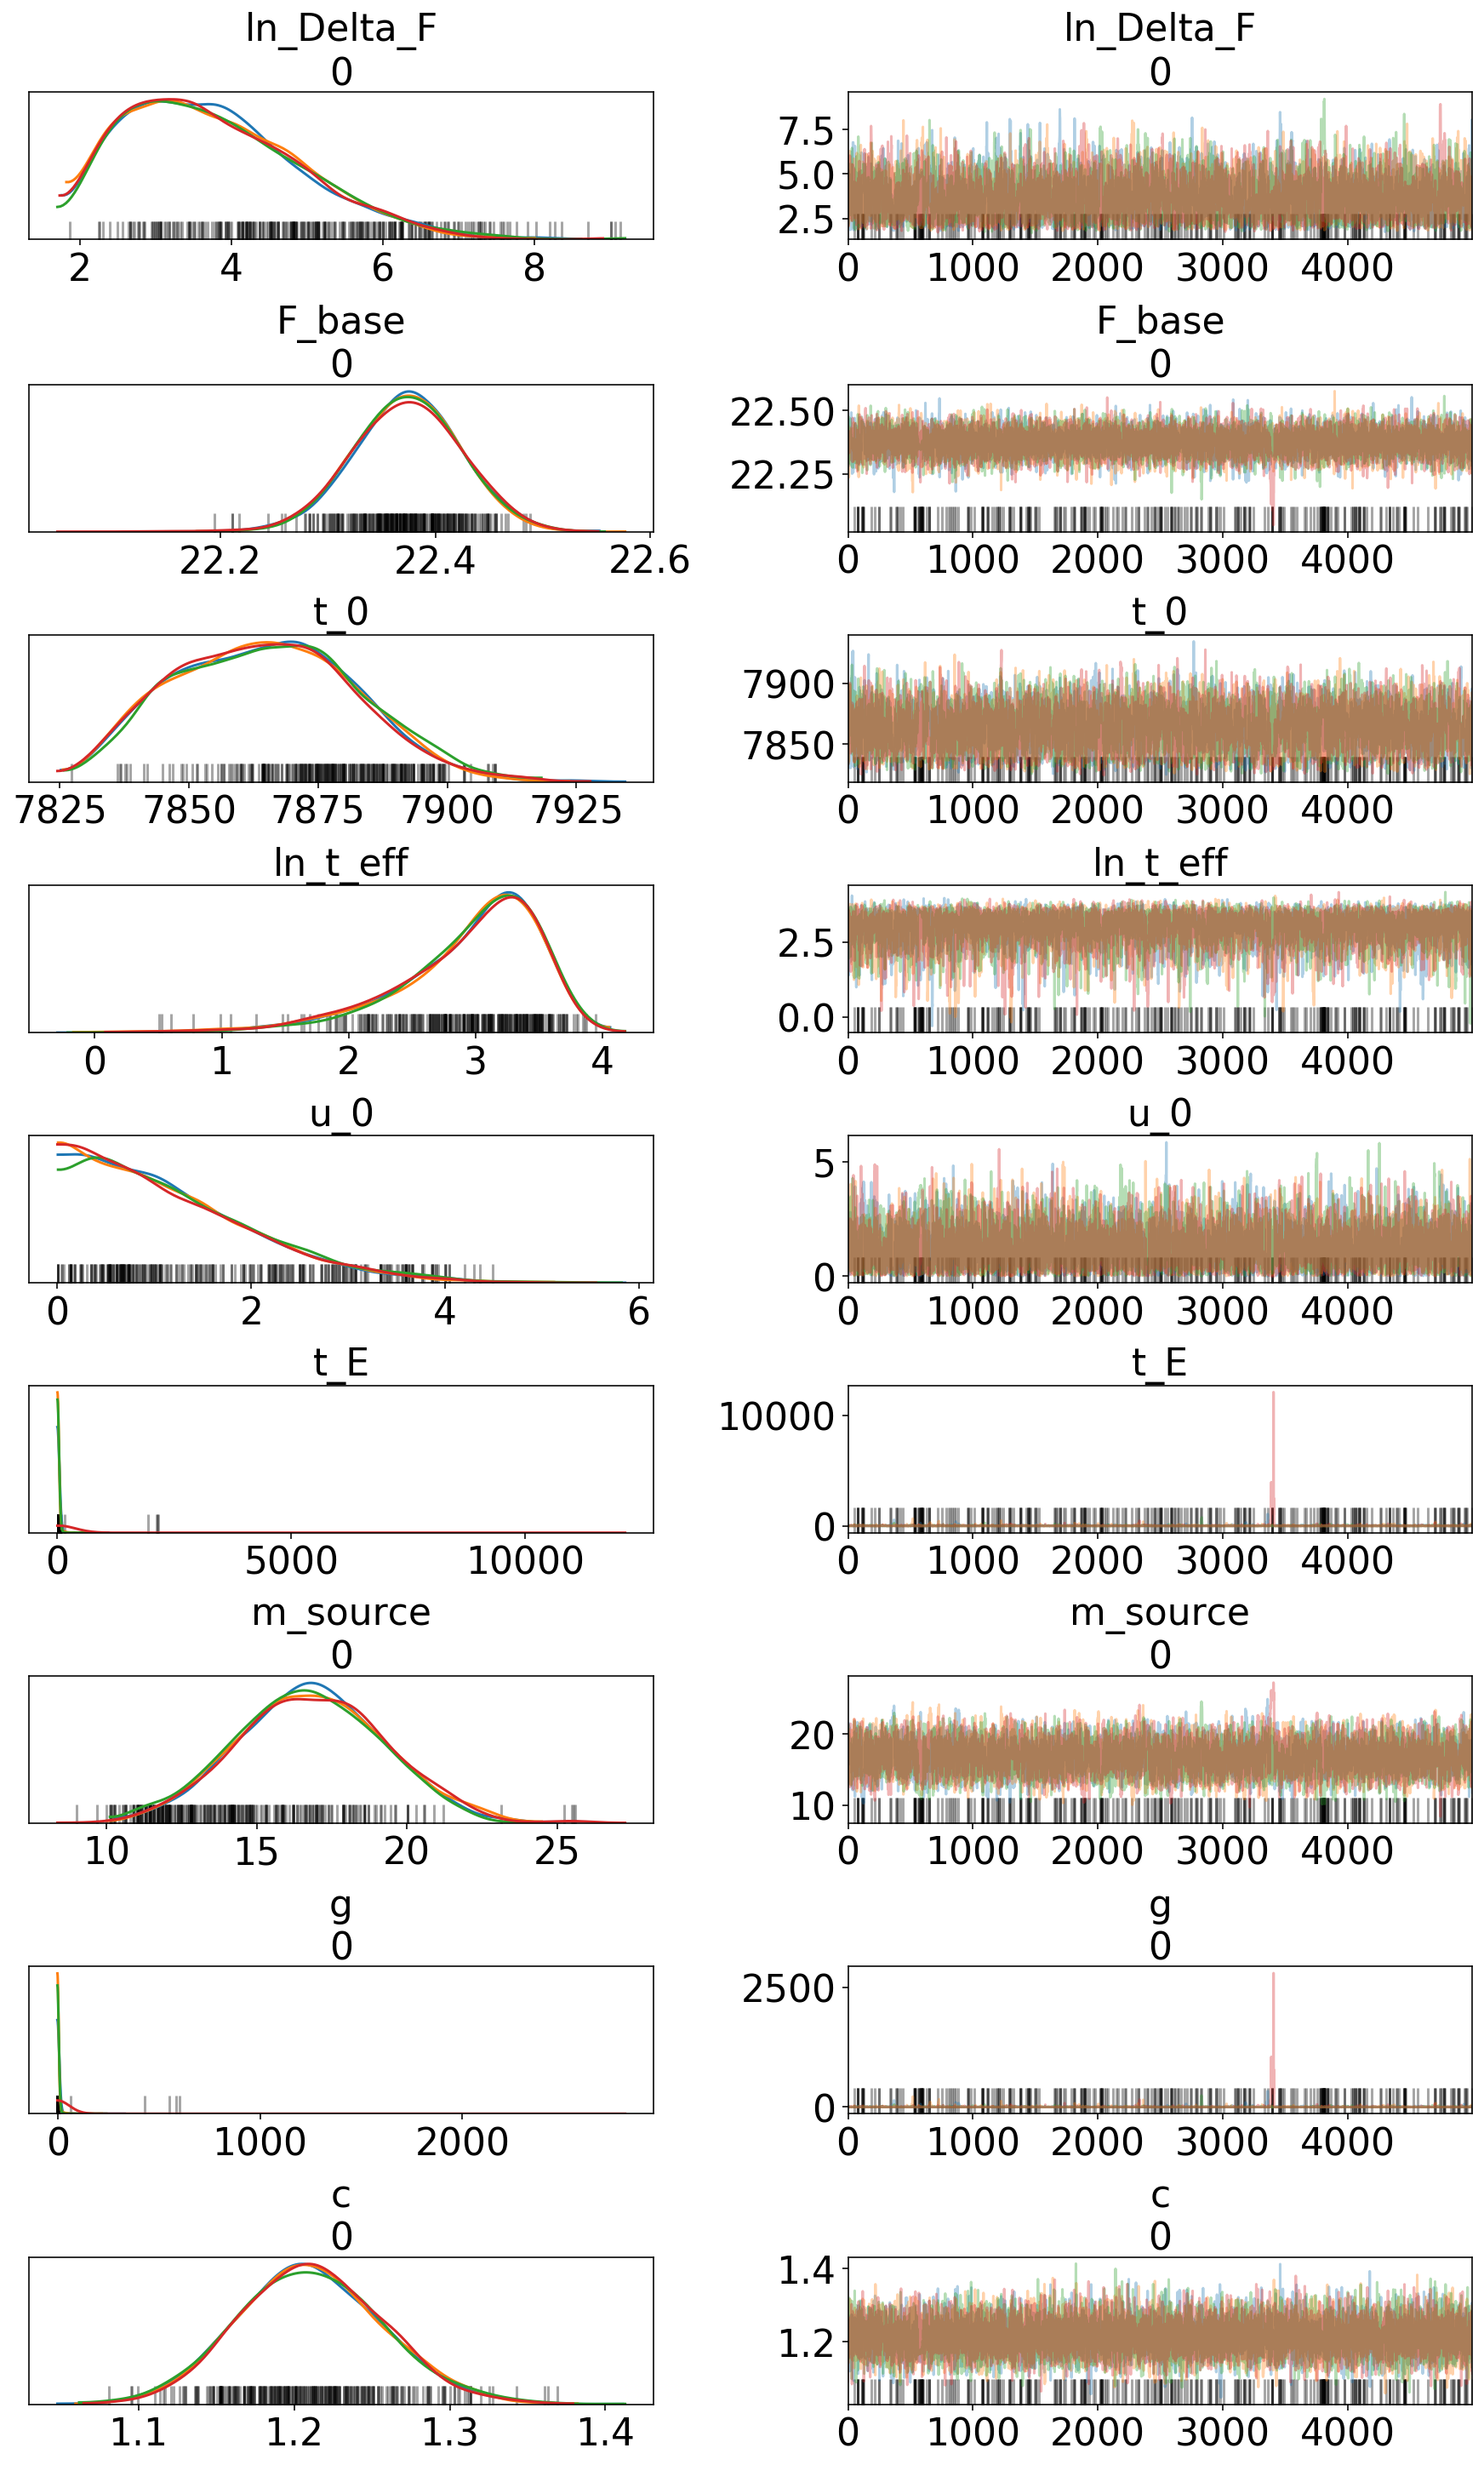

In [17]:
pm.traceplot(trace_predictive, figsize=(12, 20));

In [18]:
with model_predictive:
    # Create dense grid
    t_dense_pred = np.tile(np.linspace(model_predictive.t_min, 8000, 2000), (n_bands, 1))
    t_dense_tensor_pred = T.as_tensor_variable(t_dense_pred) 
    
    # Compute the trajectory of the lens
    u_dense_pred = trajectory.compute_trajectory(t_dense_tensor_pred)
    
    # Compute the magnification
    mag_dense_pred = model_predictive.compute_magnification(u_dense_pred, u_0)
    
    # Compute the mean model
    mean_dense_pred = T.exp(ln_Delta_F)*mag_dense_pred + F_base

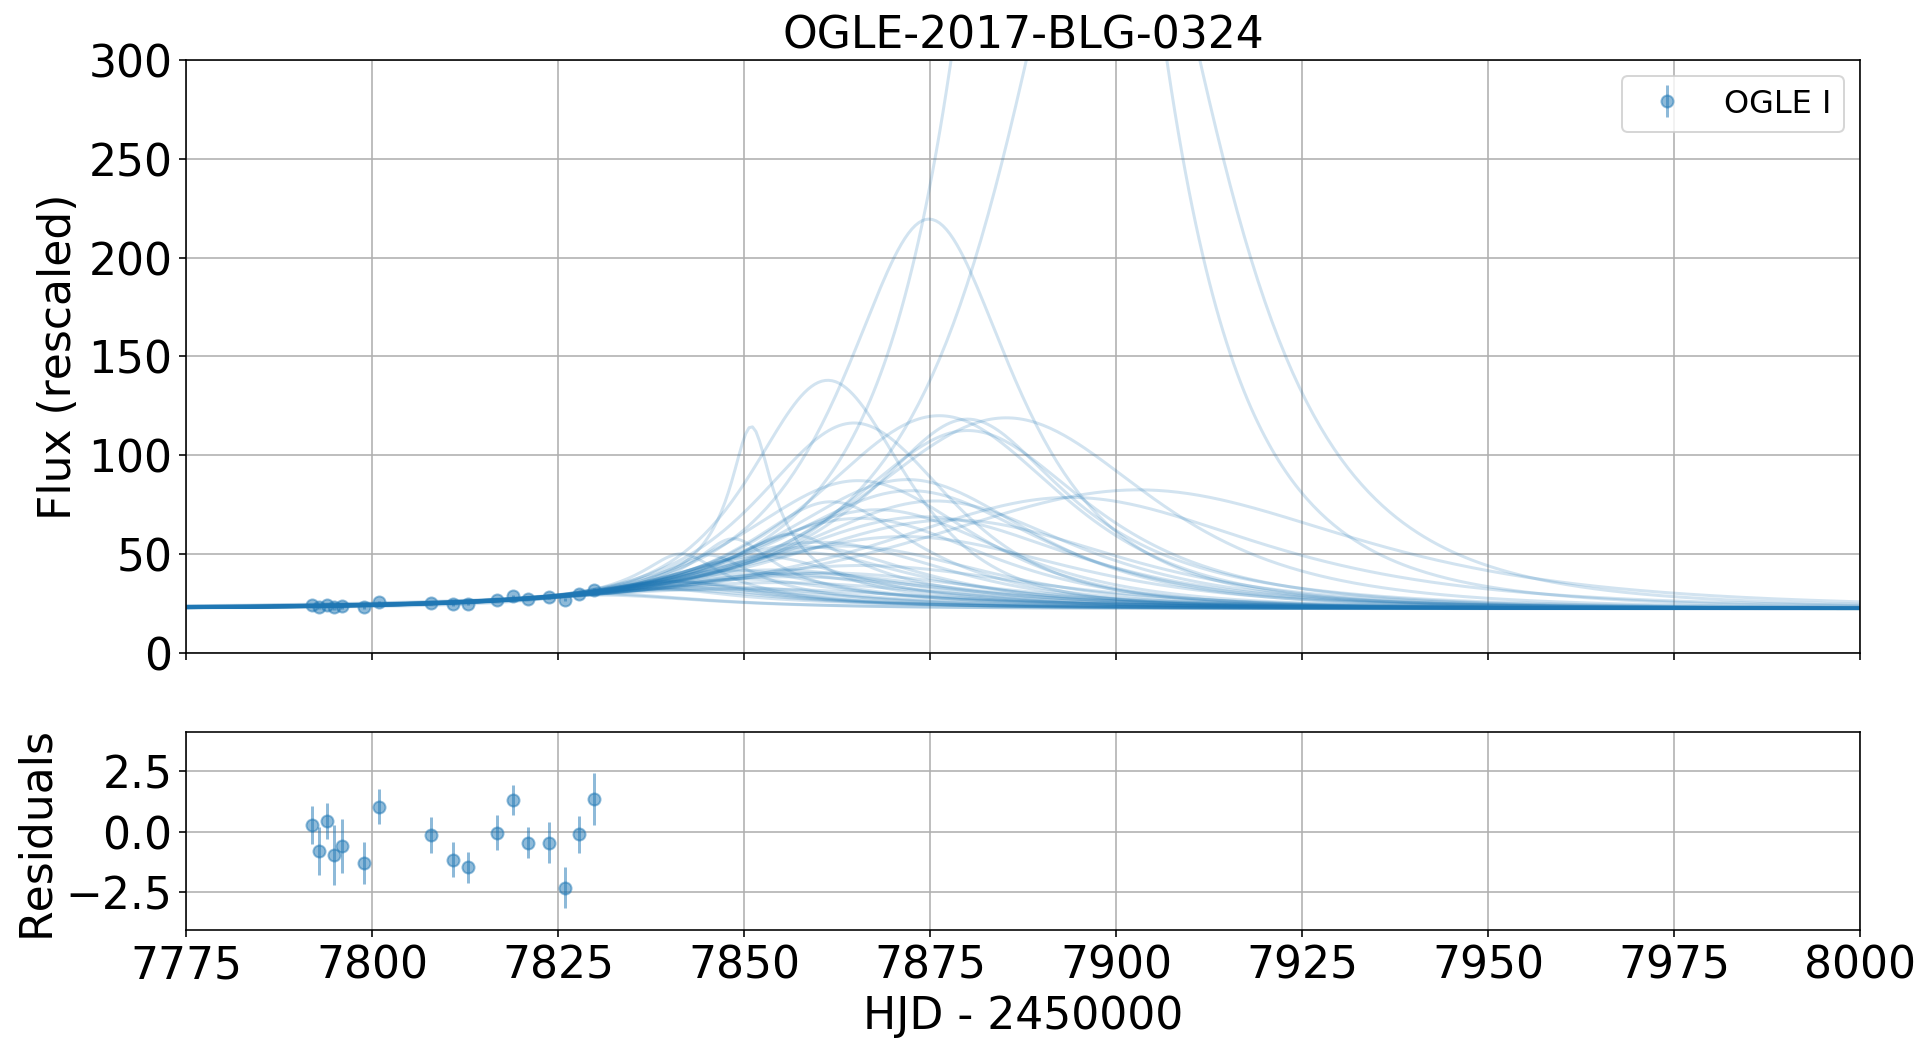

In [19]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(15, 8), sharex=True)

ax[0].set_ylim(0, 300)
ax[0].set_xlim(7775, 8000)
ca.plot_model_and_residuals(ax, event_ogle, model_predictive, trace_predictive, t_dense_tensor_pred, mean_dense_pred, n_samples=50)

Text(0.5, 1.0, 'Posterior over the $\\ln\\,\\Delta F$ parameter')

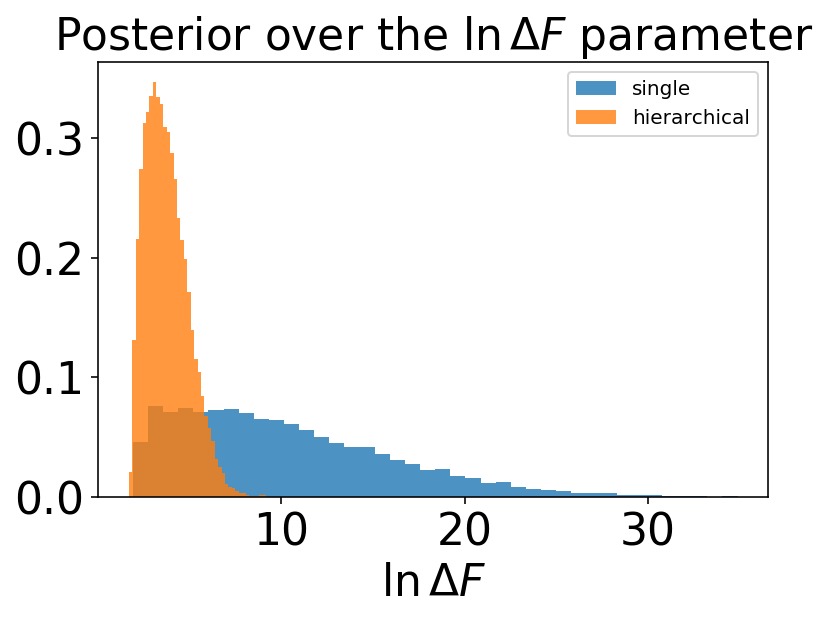

In [20]:
fig, ax = plt.subplots()
ax.hist(trace['ln_Delta_F'], bins=40, density=True, alpha = 0.8, color='C0', label='single');
ax.hist(trace_predictive['ln_Delta_F'], bins=40, density=True, alpha=0.8, color='C1', label='hierarchical');
ax.legend()
ax.set_xlabel(r'$\ln\,\Delta F$')
ax.set_title('Posterior over the $\ln\,\Delta F$ parameter')

In [21]:
def plot_model(ax, data, pm_model, trace, t_grid, prediction, color='C0'):   
    n_samples = 500
    
    # Check if trace is a PyMC3 object or a raw numpy array, extract samples
    if isinstance(trace, np.ndarray):
        trace = trace[np.random.randint(len(trace), size=n_samples)]
        # Map parameters to a dictionary which can be evaluated in model context
        samples = [pm_model.bijection.rmap(params[::-1]) for params in trace]
    else: 
        samples = xo.get_samples_from_trace(trace, size=n_samples)

    # Load data
    if pm_model.standardized_data==True:
        tables = data.get_standardized_data()
    else:
        tables = data.get_standardized_data(rescale=False)

    # Evaluate model for each sample on a fine grid
    n_pts_dense = T.shape(t_grid)[1].eval()
    n_bands = len(data.light_curves)

    prediction_eval = np.zeros((n_samples, n_bands, n_pts_dense))

    # Evaluate predictions in model context
    with pm_model:
        for i, sample in enumerate(samples):
            prediction_eval[i] = xo.eval_in_model(prediction, sample) 
    
    for i in range(n_bands):
        q = np.percentile(prediction_eval[:, i, :], [16, 84], axis=0)
        ax.fill_between(t_grid[i].eval(), q[0], q[1], color=color, alpha=0.8, lw=0)

    # Plot data
    data.plot(ax)
    ax.set_xlabel(None)
    ax.set_xlabel('HJD - 2450000')                

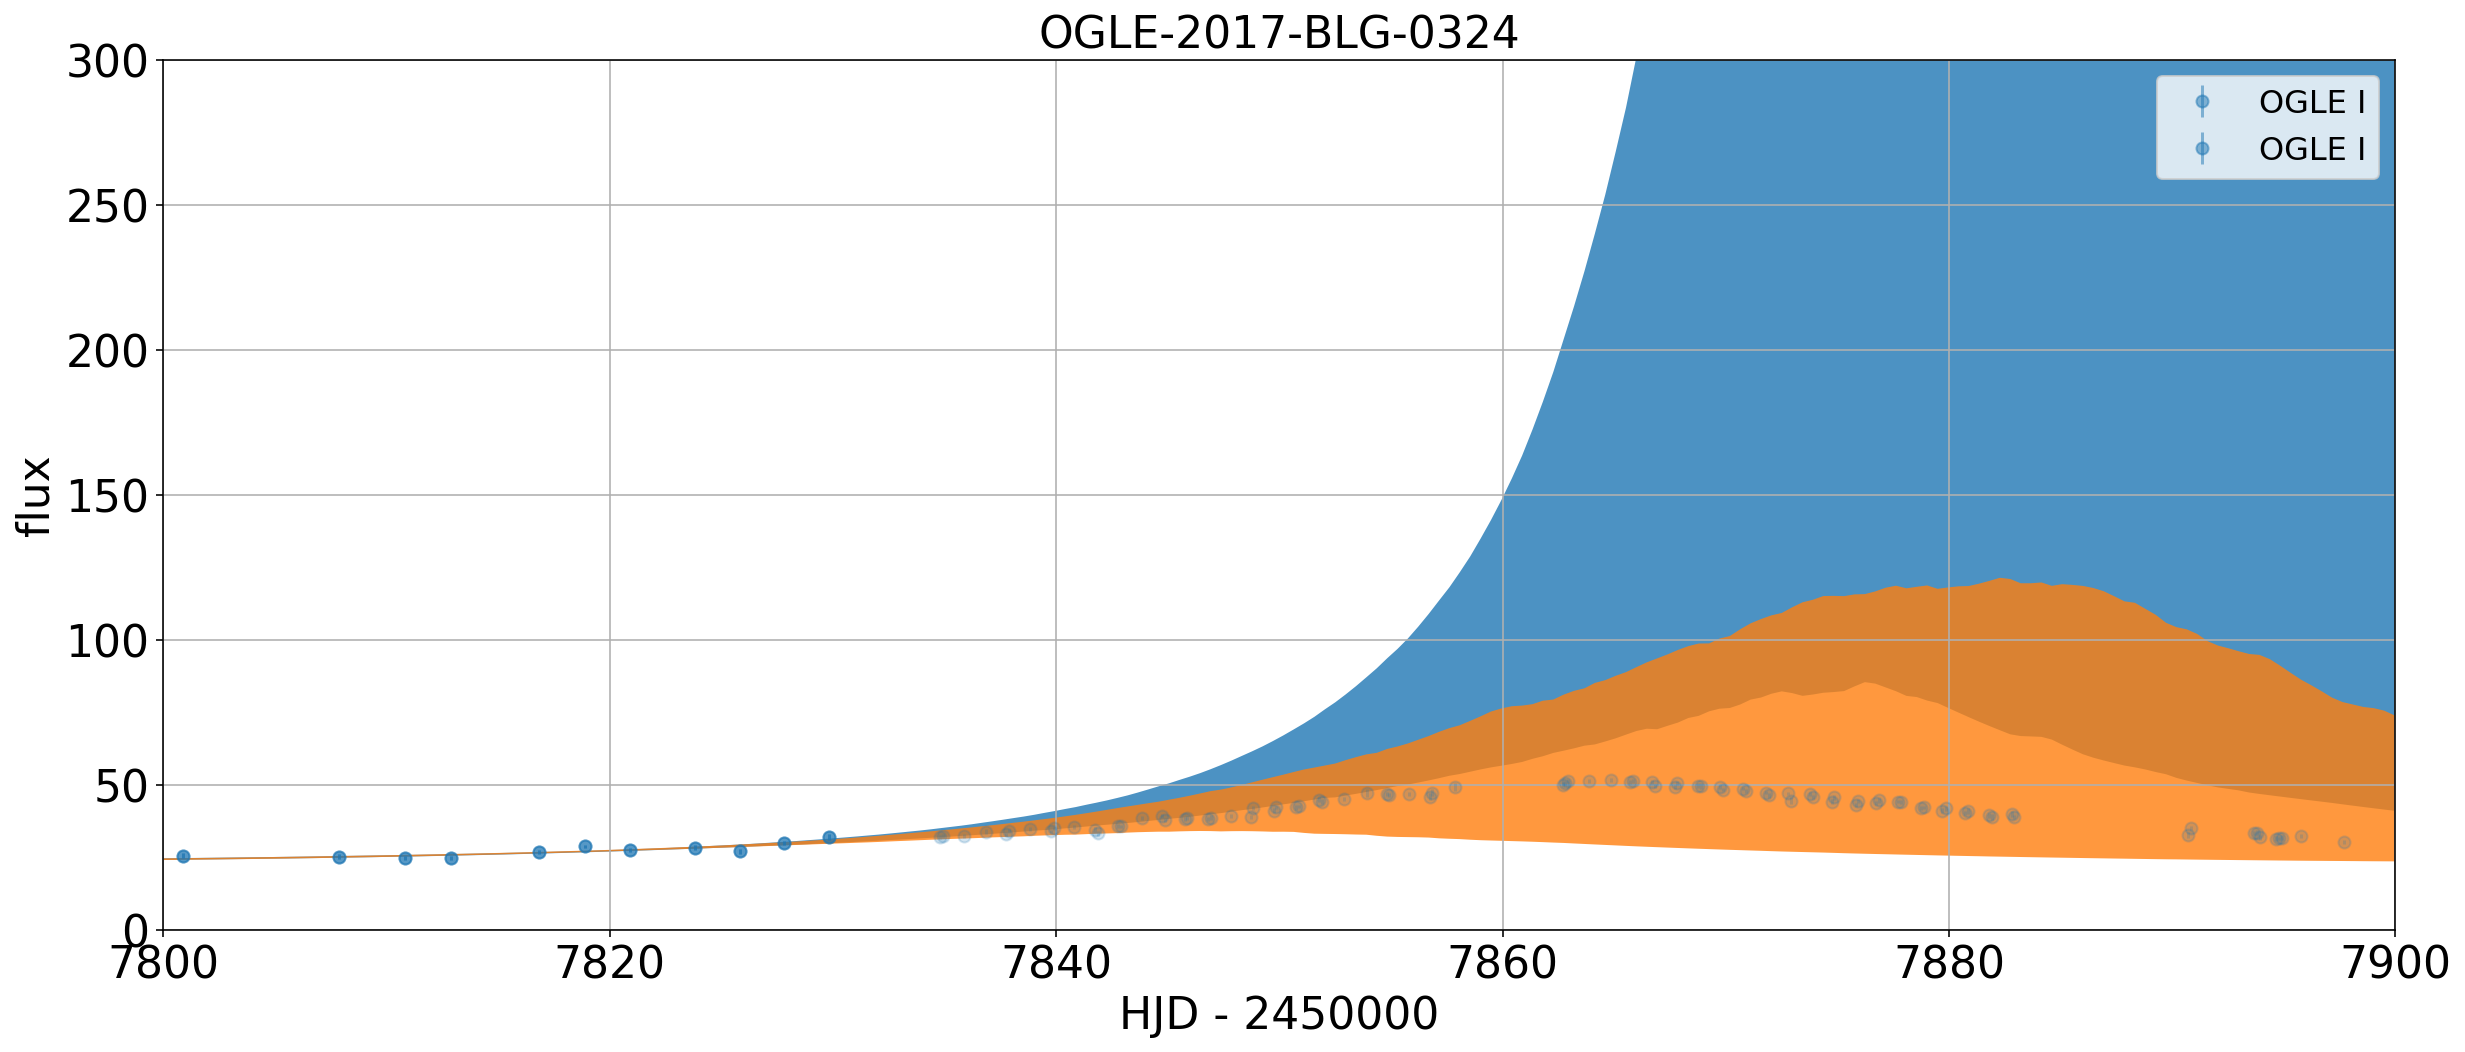

In [23]:
# Plot model
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_ylim(0, 300)
ax.set_xlim(7800, 7900)
plot_model(ax, event_ogle, pspl_model, 
                            trace, t_dense_tensor, mean_dense, color='C0')
plot_model(ax, event_ogle, model_predictive, 
                            trace_predictive, t_dense_tensor_pred, mean_dense_pred,  color='C1')